## Task 1: Visualize how often different treatments are mentioned in the forum posts
1. Reading the data
2. Looking for keyword frequency in the corpus
3. Visualizing how often each treatment category was mentioned in the corpus
4. Visualizing how often  each treatment category was mentioned over 12 months


## Task 2: Predicting forum labels
1. Reading the data
2. Preparing the feature matrix X by applying doc2vec and additionally collecting label vector y
3. Running the most popular classifiers (e.g. Logistic regression, SVM, Neural Networks) to predict the forum labels
4. Running BERT to predict the labels
5. Comparing the results


## Setting the environment 

In [1]:
import pandas as pd
import numpy as np
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure  
from scipy import stats
import nltk
from collections import defaultdict
from collections import Counter
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fatemeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fatemeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load the data


In [2]:
df_data=pd.read_parquet('./data/psoriasis_all_posts.parquet', engine='pyarrow')

df_data.head()

,post_id,text,user,timestamp,subject_id,forum_id
96315,170079,zunehmend oft höre ich über die problematik d...,Annamaria,2010-01-01 21:48:37,13338,4-community
96316,170082,"Hallo Annamaria, herzlich Willkommen hier im...",Fischi,2010-01-01 21:48:37,13338,4-community
96317,170210,"hallo, Annamaria - ich wünsche dir wirklich ...",Bibi,2010-01-01 21:48:37,13338,4-community
30501,170251,Auch ich wünsche euch ein schönes und glückli...,BlackLady,2010-01-02 10:13:06,3969,1-allgemeines
30498,170019,Ich wünsche Allen Frohes Neues Jahr GB Pics...,Bernd-57,2010-01-02 10:13:06,3969,1-allgemeines


In [3]:
data=[]
for txt in df_data['text']:
    
    data.append(txt)

In [4]:
category= defaultdict(list)

df_key = pd.read_excel('./data/keywords_psoriasis_therapies.xlsx', sheet_name='Sheet1')
                  

for index, row in df_key.iterrows():


    category[row['category']].append(row['keyword'])

## Tokenizing posts

In [5]:
def tokenizer(text):
    
    post=[]
    
    sent_text = nltk.sent_tokenize(text, language='german') 

    for sentence in sent_text:
        
        tokenized_text = nltk.word_tokenize(sentence,language='german')
        
        post.append( tokenized_text)
        
    return  post   
    
    
post_collection=[]
    
for text in data:


    post_collection.append(tokenizer(text)) 
    
    
print('number of posts in the dataset:', len(post_collection))  

number of posts in the dataset: 55888


## Number of posts per category

In [6]:
def flatten(post):
    
    flatten_post= [word for sent in post for word in sent]
    
    return flatten_post


def freq(category_words, post_collection):
    
    
    post_id=set()
    
    for i in range(len(post_collection)):
        
        flatten_post= flatten(post_collection[i])
        
        for key in category_words:
            
            if key in flatten_post:
                   
                  post_id.add(i)

                 
    return len(post_id)



cat_counter= {}

for cat in category:
    
    word_list=[word for word in category[cat]]

    cat_freq=freq(word_list, post_collection)
    
    cat_counter[cat]=cat_freq
    
    print(cat, '  number of posts',cat_freq)


Andere systemische Therapie   number of posts 1634
Andere topische Therapie   number of posts 420
Badetherapie   number of posts 382
Biologicals   number of posts 2285
Kortison   number of posts 2269
Kortison (topisch)   number of posts 640
Lichttherapie   number of posts 1476
Methotrexat   number of posts 3024
Naturheilmittel   number of posts 867
Sonstige Therapie   number of posts 463


In [7]:
labels_chart=[]
sizes=[]
for cat in cat_counter:
    
    labels_chart.append(cat)
    sizes.append(cat_counter[cat] )

## Pie Chart for the percentage of posts in each catgory

According to the pie chart "Methotrexat" is the most mentioned category in all posts. "Biologicals" and "Kortison" are the next treatments people talked about.

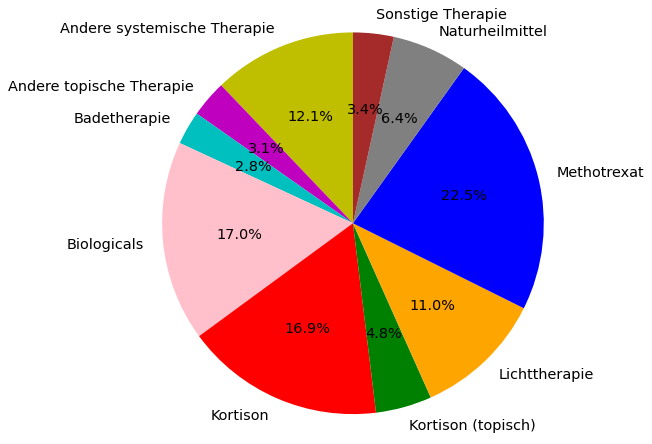

In [8]:
from matplotlib.pyplot import figure

figure(figsize=(8, 7), dpi=80)

colors=['y', 'm', 'c', 'pink', 'r', 'g', 'orange', 'b', 'gray', 'brown']

plt.pie(sizes,labels=labels_chart, colors=colors, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 13})

plt.axis('equal')

plt.show()


## Bar Chart for the percentage of posts in each catgory
According to the bar chart "Methotrexat" has the most mentioned category in all posts. 

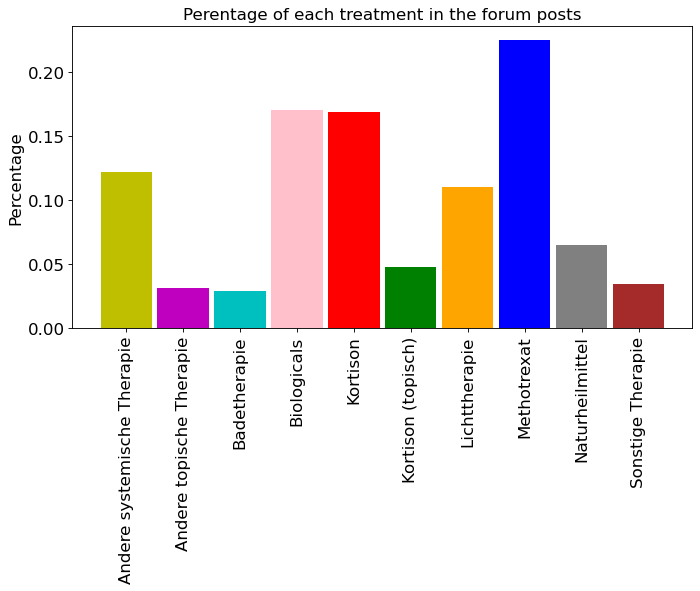

In [9]:
from matplotlib.pyplot import figure

figure(figsize=(10, 5), dpi=80)

height = [size/sum(sizes) for size in sizes]

bars = tuple(list(labels_chart))
y_pos = np.arange(len(bars))

plt.bar(y_pos, height, color=colors, width=0.9)
plt.xticks(y_pos, bars)


plt.title('Perentage of each treatment in the forum posts', fontsize=15)

plt.ylabel('Percentage', fontsize=15)
plt.xticks(rotation=90)
plt.tick_params(axis='both',labelsize=15)


## Time Series Visualization

Converting timestamp to month index

In [10]:

df_data['Date'] = pd.to_datetime(df_data['timestamp']).dt.date
df_data['Time'] = pd.to_datetime(df_data['timestamp']).dt.time
 
df_data['month'] = pd.to_datetime(df_data['Date']).dt.month

df_data.head()

,post_id,text,user,timestamp,subject_id,forum_id,Date,Time,month
96315,170079,zunehmend oft höre ich über die problematik d...,Annamaria,2010-01-01 21:48:37,13338,4-community,2010-01-01,21:48:37,1
96316,170082,"Hallo Annamaria, herzlich Willkommen hier im...",Fischi,2010-01-01 21:48:37,13338,4-community,2010-01-01,21:48:37,1
96317,170210,"hallo, Annamaria - ich wünsche dir wirklich ...",Bibi,2010-01-01 21:48:37,13338,4-community,2010-01-01,21:48:37,1
30501,170251,Auch ich wünsche euch ein schönes und glückli...,BlackLady,2010-01-02 10:13:06,3969,1-allgemeines,2010-01-02,10:13:06,1
30498,170019,Ich wünsche Allen Frohes Neues Jahr GB Pics...,Bernd-57,2010-01-02 10:13:06,3969,1-allgemeines,2010-01-02,10:13:06,1


In [11]:
month_id=set()
month_text= defaultdict(list)

for index, row in df_data.iterrows():
    
    month_text[row['month']].append (tokenizer(row['text']))
    
    month_id.add(row['month'])


In [12]:

print('number of months in the dataset:',month_id)


month_count=defaultdict(dict)


for m in month_id:
    
    post_collection=month_text[m]
    
    for cat in category:
        
        word_list=[word for word in category[cat]]

        cat_freq=freq(word_list, post_collection)  
        
        month_count[m][cat]=cat_freq

number of months in the dataset: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


In [13]:
sum_monthly={}

for m,frq in month_count.items():
    
    month_counter=0
    
    for cat in frq:
        
        month_counter=month_counter+frq[cat]
        
    sum_monthly[m]=month_counter


percent_recoder=defaultdict(dict)

for m,frq in month_count.items():
    
    for cat in frq:
        
        percentage=frq[cat]/sum_monthly[m]
        
        percent_recoder[m][cat]=percentage
  


category_percent=defaultdict(list)

for  u,v in percent_recoder.items() :
    
    for j in v.items():
        
      category_percent[j[0]].append(j[1])

## Percetange of each category in month
As shown in the chart "Methotrexat" is the highest mentioned catgory over 12 months.

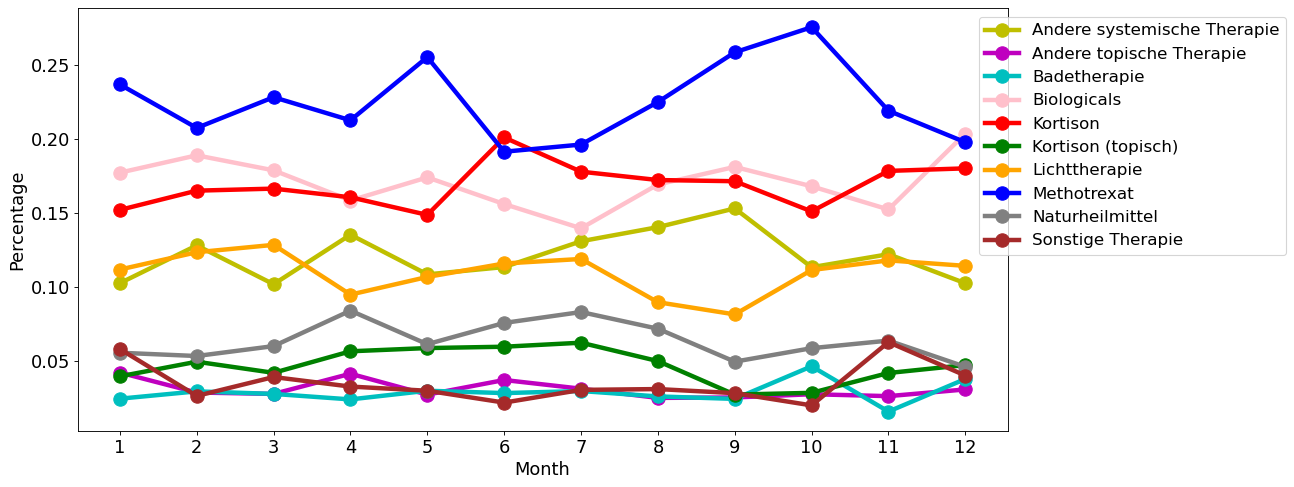

In [14]:
figure(figsize=(15, 7), dpi=80)

cat_colors={}

for i in range(len(category)):
    cat_colors[list(category)[i]]=colors[i]


chart_values={'x_values': range(1,len(month_id)+1)}

for cat in category_percent:
    
    chart_values[cat]=category_percent[cat]

df=pd.DataFrame(chart_values)

for cat in cat_colors:
   plt.plot( 'x_values', cat, 
            data=df, marker='o', markersize=12, color=cat_colors[cat], linewidth=4)


plt.ylabel('Percentage', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.xticks(list(range(1,13)))
plt.tick_params(axis='both',labelsize=16)

plt.legend(bbox_to_anchor=(0.96 ,0.999),fontsize=15)
plt.show()

# Task 2: Predicting Forum Labels

This dataset has 4 labels: '1-allgemeines', '3-klinik-reha-kur-urlaub', '4-community', '2-behandlung'

In [15]:
forum_ids=set()    
    
for ids in df_data['forum_id'] :
    
    forum_ids.add(ids)
    
print('forum_ids:', forum_ids)  

forum_ids: {'2-behandlung', '1-allgemeines', '3-klinik-reha-kur-urlaub', '4-community'}


According to the chart most ferquent forum_id is "allgemeines"

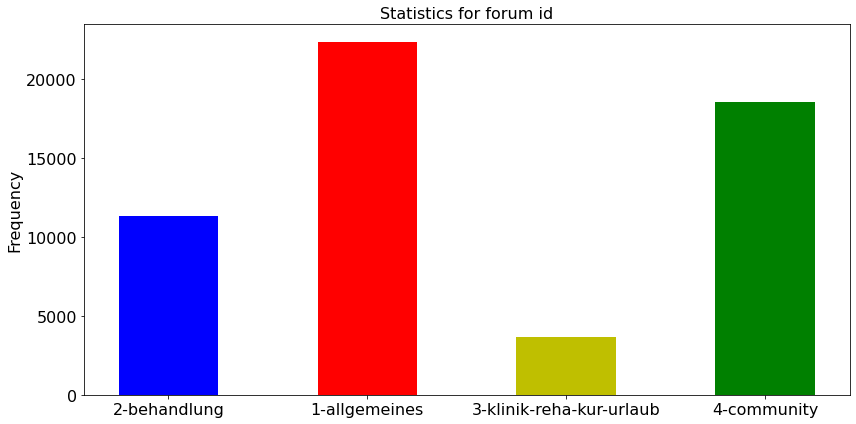

In [16]:

counter = Counter(df_data['forum_id'].tolist() )
gender_counter={}
for k,v in counter.items():
     gender_counter[k]=v

height=[]
for l in forum_ids:
      height.append(gender_counter[l])  
        
    
fig = plt.figure()
bars = tuple(forum_ids)
y_pos = np.arange(len(bars))

plt.bar(y_pos, height, color=['b', 'r', 'y','g'], width=0.5)
plt.xticks(y_pos, bars)
plt.title('Statistics for forum id', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.set_size_inches(12, 6)

plt.tick_params(axis='both',labelsize=16)
fig.tight_layout()
plt.savefig('sent-fig.pdf')



## Clean text for each post

This function cleans the posts by removing stopwords, digits and punctuations

In [17]:

def clean_post(post):
    
    clean_words=[]

    stopwords_list = stopwords.words('german')
    tok_post=tokenizer(post)
    
    
    for w in flatten(tok_post):
 
        if w in stopwords_list:
            continue
        
        if (w == ""):
            continue
            
        if  w .startswith('@'):
            continue
            
        if  w .startswith('#'):
            continue
            
            
        if  w .startswith('http'):    
            continue             

        if(w in stopwords_list):
            continue
            
        w = w.strip('0123456789') #strip digits
        w = w.strip('\'"!?$,.:;/-_<>@)(*^%][—♡❤️#')  #strip punctuation   
        
        clean_words.append(w.lower())
    
    clean_post = ' '.join(clean_words)
        
    return clean_post  


## Converting posts to vectors by Doc2vec Model

Here, we need to generate feature vectors for the given posts in the dataset. Since each post contains multiple words, we prefer to directly use doc2vec wherein generates a vector for set of words (e.g. a post). We already know that word2vec model has two algorithms: Continuous Bag of Words (CBOW) and Skip-Gram(SG). Similarly, doc2vec has also two algorithms: Distributed Bag of Words (PV-DBOW) and Paragraph Vector (PV-DM). In our experiment, we use PV-DM model thus dm=1.

In [30]:
def tagger(texts, labels):
    
      tagged_posts=[]
        
      for i in range(len(texts)):  
    
        tagged_posts.append(TaggedDocument(words=word_tokenize(texts[i]), tags=labels[i] ))
        
      return tagged_posts   


def train_doc2vec(tag_posts):
    

        
    t1= time.time()

    model_dm = Doc2Vec(dm=1, vector_size=128, negative=5, workers=5, hs=0, min_count=2, 
                                   alpha=0.025, min_alpha=0.0001)
    
    model_dm.build_vocab(tag_posts)
    train_posts  = utils.shuffle(tag_posts)
    model_dm.train(train_posts,total_examples=len(tag_posts), epochs=5)

    t2=time.time()

    print('training finished ...')
    
    return model_dm
    

In [19]:
post_list=[]
label_list=[]

for index, row in df_data.iterrows():
    

    post_list.append(clean_post(row['text']))
    label_list.append(row['forum_id'])


In [20]:
print('number of posts:', len(post_list))

number of posts: 55888


In [31]:

tag_posts=tagger(post_list,label_list)

model_dm=train_doc2vec(tag_posts) 

training finished ...


In [22]:

def feat_data(post_list,label_list,model_dm ):

    feature_vectors=[] 
    targets=[]

    for pst in tagger(post_list,label_list):
    
        vec= model_dm.infer_vector(pst.words)
        lb=pst.tags[0]

        feature_vectors.append(vec) 
        targets.append(lb)
    
    return feature_vectors, targets



In [23]:
X ,y= feat_data(post_list,label_list, model_dm)

print('number of posts:',len(X))

number of posts: 55888


## Classifiers to predict the "Forum_id"

In [24]:
import scipy.stats as stats
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE


def evaluate_model(X, y, model):
    
   cval = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
   acc_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cval, n_jobs=-1)
   f_scores= cross_val_score(model, X, y, scoring='f1_micro', cv=cval, n_jobs=-1)

   return acc_scores,f_scores

def clf_models():
    
    models, names = list(), list()
    
    models.append(DummyClassifier(strategy='uniform'))
    names.append('DuM')
    
    models.append(LogisticRegression(solver='lbfgs'))
    names.append('LR ')
    
    models.append(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 4), random_state=42))
    names.append('NN ')
    
    models.append(KNeighborsClassifier())
    names.append('KNN')
    
    models.append(DecisionTreeClassifier())
    names.append('DT ')
    
    models.append(LinearSVC())
    names.append('SVM')
    
    return models, names


models, names = clf_models()

f=open('./data/cls_results.txt','w')

plt_scores=[]


for i in range(len(models)):
   steps = [('o', SMOTE(k_neighbors=2)), ('m', models[i])]
    
   pipeline = Pipeline(steps=steps)
    
   acc_scores ,f_scores = evaluate_model(X ,y, pipeline)
   plt_scores.append(f_scores)
   print('====> %s    accuracy: %.4f (std %.4f)     F1: %.4f (std %.4f)' 
         % (names[i], mean(acc_scores), std(acc_scores), mean(f_scores), std(f_scores)))
   
   f.write( str(names[i])+' F1: '+str(mean(f_scores)) +' Acc '+str(mean(acc_scores)) )
   f.write('\n')

f.close()   

====> DuM    accuracy: 0.2487 (std 0.0034)     F1: 0.2501 (std 0.0042)
====> LR     accuracy: 0.6299 (std 0.0040)     F1: 0.6298 (std 0.0039)
====> NN     accuracy: 0.6321 (std 0.0041)     F1: 0.6317 (std 0.0037)
====> KNN    accuracy: 0.3438 (std 0.0041)     F1: 0.3438 (std 0.0057)
====> DT     accuracy: 0.3698 (std 0.0048)     F1: 0.3712 (std 0.0036)
====> SVM    accuracy: 0.6305 (std 0.0036)     F1: 0.6307 (std 0.0033)


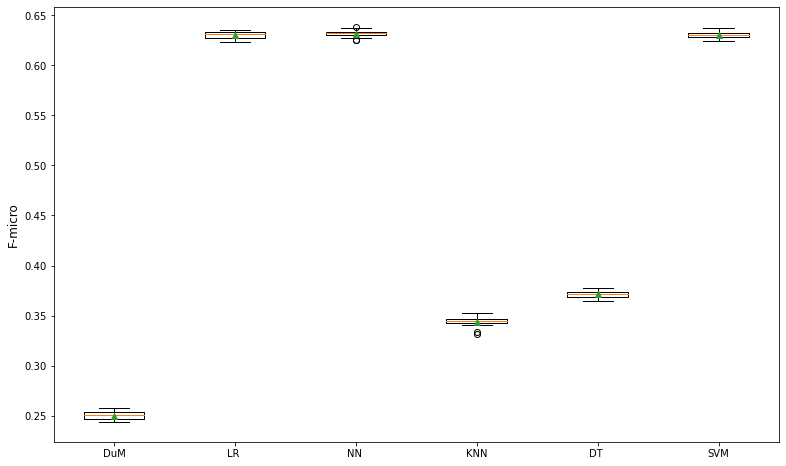

In [27]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(13, 8)
plt.ylabel('F-micro', fontsize=12)
plt.boxplot(plt_scores, labels=names, showmeans=True)
plt.show()

# Evaluation

We have tried multiple classifiers. The Dummy classifier is indeed the baseline of our prediction that performs a random guess. The performance of each method is measured by F1 score as we deal with a multi-class classification problem.  F-score only returns higher values if both  Precision and Recall are high. We report the results after 5-fold cross validation along with standard deviation (std) proportional to the mean.

Looking at the detail presented in the box chart, Logistic Regression (LR), Feedforward Neural Network (NN) and SVM are presenting nearly the same performance with F1=0.63. While K-Nearest Neighbors (KNN) and Decsion Tree (DT) are not working well on the features generated by doc2vec. The small std value confirms the results are consistent across multiple corss-validations.

Additionally we conduct the forum post classification via BERT. With one iteration the performance stays around F1=0.587 which is worse than doc2vec model, however with more iterations the performance can raise. 


To scale up the computation for millions of data items, we can use PySpark. PySpark is a powerful open source engine that provides interactive processing, in-memory processing as well as batch processing with high speed and ease of use.  The ML library of PySpark contains most conventional classification and clustering algorithms located in pyspark.ml.
